In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d

from jupyter_server import serverapp as app; 
import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

# sns.set_style("ticks")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
sns.reset_defaults()

In [3]:
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [4]:
home = os.path.expanduser("~")
project_path =  '..'
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [5]:
import analysis.mathematical_functions.funcs as funcs

In [6]:
data_folder = os.path.relpath('../data/parameter_runs/proper_pd_3/')
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [7]:
output_folder = os.path.relpath('../3_outputs')

In [8]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [9]:
R0s = np.array(sorted(list(set(datadf['infection_rate']))))
mu_s = np.array(sorted(list(set(datadf['mutation_rate']))))
xi_s = np.array(sorted(list(set(datadf['xi']))))
kappa_s = np.array(sorted(list(set(datadf['kappa']))))
N = datadf['N'].unique()[0]

In [10]:
%load_ext autoreload

In [11]:
cwd = os.getcwd()
folder_name = cwd.split('/')[-1]

parallel_subfolder= 'results'
results_folder = os.path.relpath(project_path+'/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [12]:
if len(data_files)==1:
    dataname = data_files[0][funcs.find_end_substring(data_files[0],parallel_subfolder)+1: data_files[0].find('abm')]
    results_name = results_folder+'/'+dataname
    results_name = 'results/'
else:
    raise ValueError

In [13]:
def get_p_evo_from_df(R0,mu,xi, kappa, datadf, pbar = None):
    dpdf = datadf.query(f'infection_rate =={R0} & mutation_rate=={mu} & xi=={xi} & kappa=={kappa}')
    if pbar is not None:
        pbar.update(1)
    return 1-len(dpdf[datadf.isin([np.inf, -np.inf]).any(axis=1)])/len(dpdf)

In [14]:
prog_bar = tqdm(total= len(list(funcs.product(mu_s,xi_s,R0s, kappa_s))))
if not os.path.exists(results_name+'p_evo_df.feather'):
    p_evo_df = pd.DataFrame.from_dict({i:(mu,xi,r, kappa ,get_p_evo_from_df(r,mu,xi, kappa ,datadf,prog_bar)) for i,(mu,xi,r,kappa) in tqdm(enumerate(funcs.product(mu_s,xi_s,R0s, kappa_s)))},orient='index', columns=['mu','xi','R0', 'kappa','p_evo'])
    p_evo_df.to_feather(results_name+'p_evo_df.feather')
else:
    p_evo_df = pd.read_feather(results_name+'p_evo_df.feather')
p_evo_df['p_alpha'] = datadf['p_alpha'].unique()[0]
p_evo_df['N'] = datadf['N'].unique()[0]
p_evo_df['mu'] = datadf['mutation_rate'].unique()[0]
p_evo_df['xi_d']=  -1/np.log(1-p_evo_df['p_alpha'])
p_evo_df['mut_strength'] = p_evo_df['xi_d']/p_evo_df['xi'] * np.log(p_evo_df['mu']*p_evo_df['N'])
p_evo_df['kappa_plot'] = 1 + np.round(p_evo_df['kappa'],2)



  0%|          | 0/1320 [00:00<?, ?it/s]

In [15]:
x_mu_strengths = p_evo_df['mut_strength'].unique()
x_mu_strengths = np.sort(x_mu_strengths)

In [16]:
import matplotlib.colors as mcolors
colors_kappa = funcs.color_dict(kappa_s, plt.cm.plasma_r)

In [17]:
def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))

def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,100000)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [18]:
@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv
            
def get_product_sum_proba_ode(R0,kappa,N, p_alpha, xi, track_progress=False):
    d_alpha = int(1/p_alpha)
    ds = np.arange(1,10*d_alpha)
    
    fit_d = lambda x,y,z, d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    ts, solution = integrate_trajectory(R0,kappa,N)
    x, y = solution/N
    z = 1-x-y

    product_sum = np.zeros_like(ts)
    for d in tqdm(ds, disable=not track_progress):
        f = fit_d(x,y,z,d)
        product_sum += funcs.rho_d(d=d,p_alpha=p_alpha )*get_p_surv_inv_int(f, ts[1]-ts[0])

    return ts, product_sum

def get_exp_num_established_ode(R0,kappa,N, p_alpha, xi, track_progress=False):
    d_alpha = int(1/p_alpha)
    ds = np.arange(1,10*d_alpha)

    fit_d = lambda x,y,z, d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    ts, solution = integrate_trajectory(R0,kappa,N)
    x, y = solution/N
    z = 1-x-y

    # new_f = fit_d(new_x,new_y,new_z,d)
    product_sum = np.zeros_like(ts)
    for d in tqdm(ds, disable=not track_progress):
        f = fit_d(x,y,z,d)
        pi_direct = get_p_surv_inv_int(f, ts[1]-ts[0])
        product_sum += funcs.rho_d(d=d,p_alpha=p_alpha )*pi_direct

    exp_num_est = np.trapz(product_sum*y , ts)*N
    return exp_num_est


In [19]:
import scipy.optimize as so
R0 = R0s[2]
mu=p_evo_df['mu'].unique()[0]
N = p_evo_df['N'].unique()[0]
p_alpha = p_evo_df['p_alpha'].unique()[0]



if not os.path.exists(results_name+'exp_t_dep_nums_ode_df.feather'):
    exp_t_dep_nums_df = pd.DataFrame.from_dict({i:(xi, R0, kappa, mu*get_exp_num_established_ode(R0=R0, kappa = kappa, p_alpha=p_alpha,xi = xi, N=N)) for i,(xi,R0,kappa) in enumerate(funcs.product(xi_s,R0s,kappa_s))},orient='index', columns=['xi','R0', 'kappa','exp_num_est_mutants'])
    exp_t_dep_nums_df['mu']= mu
    exp_t_dep_nums_df['N']= N
    exp_t_dep_nums_df['p_alpha']= p_alpha
    exp_t_dep_nums_df['kappa_plot']= 1+exp_t_dep_nums_df['kappa']
    exp_t_dep_nums_df['mut_strength'] =1/(exp_t_dep_nums_df['xi']*exp_t_dep_nums_df['p_alpha']) * np.log(exp_t_dep_nums_df['mu']*exp_t_dep_nums_df['N'])
    exp_t_dep_nums_df["p_alpha"]= p_alpha
    exp_t_dep_nums_df["p_evo"]= 1-np.exp(-exp_t_dep_nums_df["exp_num_est_mutants"])
    exp_t_dep_nums_df.to_feather(results_name+'exp_t_dep_nums_ode_df.feather')
else:
    exp_t_dep_nums_df = pd.read_feather(results_name+'exp_t_dep_nums_ode_df.feather')


In [20]:
p_evo_df['error_p_evo'] = np.sqrt(p_evo_df['p_evo']*(1-p_evo_df['p_evo'])/1000)

2.4703649310695934


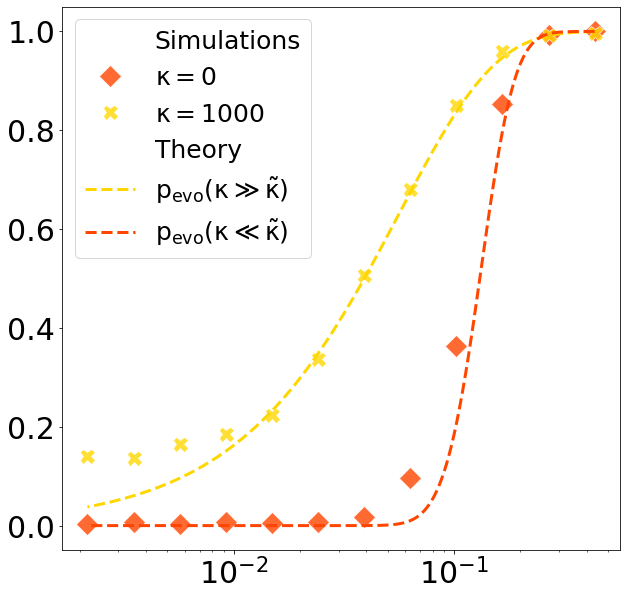

In [21]:
p_evo_df['scaled_d'] = 1/(p_evo_df['xi'] * p_evo_df['p_alpha']) 
p_evo_df['p_ext']= 1-p_evo_df['p_evo']


delta_s = 1/(xi_s*p_alpha) 
delta_s_plot= np.logspace(np.log(delta_s[0]),np.log(delta_s[-1]),1000,base=np.e)
savefig = True

for R0 in R0s[5:6]:
    print(R0)
    zinf_inf = (R0-1)/R0
    fig,ax = plt.subplots(1,1,figsize=(10,10),sharey=True)
    # plt.plot(kappa_s, 1-np.exp(-np.array(exp_t_dep_nums)), 'o')
    # plt.plot(kappa_s, 1-np.exp(-np.array(exp_t_dep_nums_adiabatic)), 'X')
    sns.lineplot(p_evo_df
        .query(f'R0=={R0} & p_alpha=={p_alpha} & kappa== {0} '), x='scaled_d', y='p_evo', ax=ax, legend=None,alpha=.8, color='orangered', linestyle='',marker ='D',ms=15, label = r'$simulations, \kappa=0$')
    sns.lineplot(p_evo_df
        .query(f'R0=={R0} & p_alpha=={p_alpha} & kappa== {kappa_s[-1]} '), x='scaled_d', y='p_evo', ax=ax, legend='brief',alpha=.8, color='gold',linestyle='',marker ='X',ms=15, label = r'$simulations, \kappa=1000$')

    m_strength = 1/(xi_s*p_alpha) * np.log(mu*N)
    
    exp_val = mu*N*delta_s_plot * ((R0-1)/R0)**2 /2
    exp_val_alt= mu*N*delta_s_plot * (-zinf_inf- np.log(1-zinf_inf) )/2
    p_evo_kappa0 = 1- np.exp(-mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-1/delta_s_plot) )    

    # label_k_inf = r'$ 1-\mathrm{e}^{- \frac{\mu N}{2} \frac{ \langle d \rangle}{\xi} \left( \frac{R_0-1}{R_0}\right) ^2}$'
    label_k_inf = r'$p_\mathrm{evo}\left(\kappa\gg\tilde{\kappa}\right)$'
    # label_k_0 = r'$ 1-\mathrm{e}^{- \mu N\; \frac{\log R_0}{R_0} \left(\frac{R_0}{R_0-1}\right)^{-\xi/\langle d\rangle}}$'
    label_k_0 = r'$p_\mathrm{evo}\left(\kappa\ll\tilde{\kappa}\right)$'
    
    ax.plot(delta_s_plot ,1-np.exp(-exp_val), color='gold',ms=20,label=label_k_inf,linestyle='--')
    ax.plot(delta_s_plot ,p_evo_kappa0, ms=10, color= 'orangered', label=label_k_0,linestyle='--')

    ax.set_xscale('log')
    ax.set_xlabel(r'')
    ax.set_ylabel(r'')

    handles, labels = ax.get_legend_handles_labels()
    labels = ['Simulations', r'$\kappa=0$', r'$\kappa=1000$', 'Theory', label_k_inf, label_k_0]
    empty_handle = mpl.lines.Line2D([], [], linestyle='none', label='')
    handles = [empty_handle, handles[0], handles[1], empty_handle, handles[2], handles[3]]

    ax.legend(handles,labels, loc= 'best', fontsize= 25)

    if savefig: plt.savefig(output_folder+f'/fig3_R0_{R0:.1f}.svg', bbox_inches='tight')